In [1]:
import os
import requests

import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiplicativeLR

from OrnsteinUhlenbeck.n_standart_ou import VasicekModel, mle_ou

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dt = 0.01
t = np.arange(0, 100, dt)

In [4]:
q = {"s_0": 0.0, "kappa": 0.5, "theta": 2.0, "sigma": 0.5}

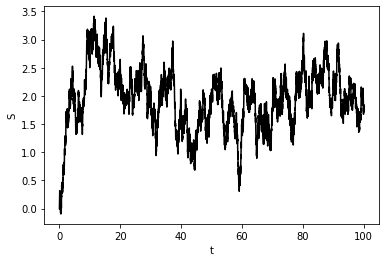

In [5]:
ou = VasicekModel(**q)
x = ou.path(t)

plt.xlabel("t")
plt.ylabel("S")
plt.plot(t, x, color="black")

In [6]:
train_size = int(len(x) * 0.8)

#LSTM preprocess
X = [[v] for v in x]

# Vasicek preprocess
v_train, v_test = list(x[:train_size]), x[train_size:]

# Prev value prediction baseline

Test MSE: 0.002457


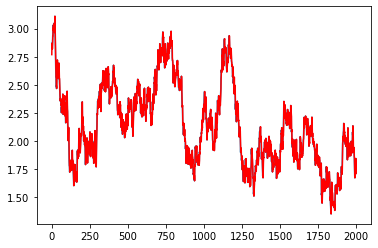

In [7]:
predictions = [v_train[-1]]
predictions.extend(v_test[:-1])
    
error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)

# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

# Vasicek

In [8]:
result = mle_ou(t[:train_size], v_train)
kappa = result.params["kappa"].value
theta = result.params["theta"].value
sigma = result.params["sigma"].value
q_predicted = {"kappa": kappa, "theta": theta, "sigma": sigma}
print(q_predicted)

{'kappa': 0.43932207930564526, 'theta': 1.9725207708379586, 'sigma': 0.5045660664092338}


In [9]:
np.random.seed(2)

def predict(s_t, kappa, theta, sigma):
    return s_t + kappa * (theta - s_t) * dt + sigma * np.sqrt(dt) * np.random.normal()

In [10]:
v_train[-1]

2.7692263251490803

In [11]:
predict(v_train[-1], **q_predicted)

2.7446980349708814

Test MSE: 0.004954


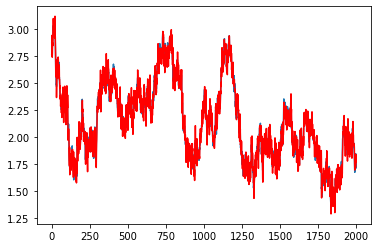

In [12]:
predictions = [predict(v_train[-1], **q_predicted)]

for s in v_test[:-1]:
    predictions.append(predict(s, **q_predicted))

    
error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)

# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              dropout=0.2, batch_first=True)
        self.lstm_3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              dropout=0.2, batch_first=True)
        
        self.fc = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
        output, (hn, cn) = self.lstm_1(x, (h_0, c_0))
        output, (hn, cn) = self.lstm_2(output, (hn, cn))
        output, (hn, cn) = self.lstm_3(output, (hn, cn))
        hn = hn.view(-1, self.hidden_size)
        
        out = self.fc(hn)
        return out

In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              batch_first=True)
        self.lstm_3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              batch_first=True)
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
        output, (hn, cn) = self.lstm_1(x, (h_0, c_0))
        output, (hn, cn) = self.lstm_2(output, (hn, cn))
        output, (hn, cn) = self.lstm_3(output, (hn, cn))
        hn = hn.view(-1, self.hidden_size)
        
        out = self.relu(hn)
        out = self.fc(out)
        
        return out

In [15]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [16]:
seq_length = 50

lstm_x, lstm_y = sliding_windows(X, seq_length)

test_size = len(lstm_y) - train_size

trainX = torch.Tensor(np.array(lstm_x[0:train_size]))
trainY = torch.Tensor(np.array(lstm_y[0:train_size]))

testX = torch.Tensor(np.array(lstm_x[train_size:len(lstm_x)]))
testY = torch.Tensor(np.array(lstm_y[train_size:len(lstm_y)]))

In [17]:
dataloaderX = DataLoader(trainX, batch_size=20000, shuffle=False)
dataloaderY = DataLoader(trainY, batch_size=20000, shuffle=False)
test_dataloaderX = DataLoader(testX, batch_size=20000, shuffle=False)
test_dataloaderY = DataLoader(testY, batch_size=20000, shuffle=False)

In [18]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 50
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.995) 

# Train the model
for epoch in range(num_epochs):
    for batch_ind, (x_batch, y_batch) in enumerate(zip(dataloaderX, dataloaderY)):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = lstm(x_batch)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    scheduler.step()
        
#         print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")
    print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")

Epoch: 0, Batch: 0 loss: 3.7559332847595215
Epoch: 1, Batch: 0 loss: 3.2822086811065674
Epoch: 2, Batch: 0 loss: 2.0337977409362793
Epoch: 3, Batch: 0 loss: 0.7541482448577881
Epoch: 4, Batch: 0 loss: 0.36092498898506165
Epoch: 5, Batch: 0 loss: 0.32581567764282227
Epoch: 6, Batch: 0 loss: 0.4134514331817627
Epoch: 7, Batch: 0 loss: 0.48023197054862976
Epoch: 8, Batch: 0 loss: 0.492783784866333
Epoch: 9, Batch: 0 loss: 0.4632296860218048
Epoch: 10, Batch: 0 loss: 0.41309815645217896
Epoch: 11, Batch: 0 loss: 0.36301088333129883
Epoch: 12, Batch: 0 loss: 0.32814887166023254
Epoch: 13, Batch: 0 loss: 0.3145422339439392
Epoch: 14, Batch: 0 loss: 0.31915876269340515
Epoch: 15, Batch: 0 loss: 0.33377987146377563
Epoch: 16, Batch: 0 loss: 0.34956520795822144
Epoch: 17, Batch: 0 loss: 0.3601985573768616
Epoch: 18, Batch: 0 loss: 0.3628860414028168
Epoch: 19, Batch: 0 loss: 0.3579464256763458
Epoch: 20, Batch: 0 loss: 0.34777119755744934
Epoch: 21, Batch: 0 loss: 0.33565419912338257
Epoch: 22,

Epoch: 180, Batch: 0 loss: 0.3142262399196625
Epoch: 181, Batch: 0 loss: 0.3142260015010834
Epoch: 182, Batch: 0 loss: 0.31422579288482666
Epoch: 183, Batch: 0 loss: 0.3142254948616028
Epoch: 184, Batch: 0 loss: 0.31422528624534607
Epoch: 185, Batch: 0 loss: 0.31422504782676697
Epoch: 186, Batch: 0 loss: 0.31422480940818787
Epoch: 187, Batch: 0 loss: 0.3142245411872864
Epoch: 188, Batch: 0 loss: 0.3142242729663849
Epoch: 189, Batch: 0 loss: 0.314223974943161
Epoch: 190, Batch: 0 loss: 0.3142237067222595
Epoch: 191, Batch: 0 loss: 0.31422340869903564
Epoch: 192, Batch: 0 loss: 0.31422317028045654
Epoch: 193, Batch: 0 loss: 0.3142228424549103
Epoch: 194, Batch: 0 loss: 0.314222514629364
Epoch: 195, Batch: 0 loss: 0.31422221660614014
Epoch: 196, Batch: 0 loss: 0.31422188878059387
Epoch: 197, Batch: 0 loss: 0.3142215609550476
Epoch: 198, Batch: 0 loss: 0.31422120332717896
Epoch: 199, Batch: 0 loss: 0.3142209053039551
Epoch: 200, Batch: 0 loss: 0.3142205476760864
Epoch: 201, Batch: 0 loss: 

Epoch: 358, Batch: 0 loss: 0.20241668820381165
Epoch: 359, Batch: 0 loss: 0.19430840015411377
Epoch: 360, Batch: 0 loss: 0.1872614473104477
Epoch: 361, Batch: 0 loss: 0.1816515028476715
Epoch: 362, Batch: 0 loss: 0.17623819410800934
Epoch: 363, Batch: 0 loss: 0.17153388261795044
Epoch: 364, Batch: 0 loss: 0.1642334908246994
Epoch: 365, Batch: 0 loss: 0.1577558070421219
Epoch: 366, Batch: 0 loss: 0.15226441621780396
Epoch: 367, Batch: 0 loss: 0.14788083732128143
Epoch: 368, Batch: 0 loss: 0.14561176300048828
Epoch: 369, Batch: 0 loss: 0.14317841827869415
Epoch: 370, Batch: 0 loss: 0.1387396901845932
Epoch: 371, Batch: 0 loss: 0.12953227758407593
Epoch: 372, Batch: 0 loss: 0.12904153764247894
Epoch: 373, Batch: 0 loss: 0.12836839258670807
Epoch: 374, Batch: 0 loss: 0.11883757263422012
Epoch: 375, Batch: 0 loss: 0.11860879510641098
Epoch: 376, Batch: 0 loss: 0.11684910953044891
Epoch: 377, Batch: 0 loss: 0.10899822413921356
Epoch: 378, Batch: 0 loss: 0.10998398065567017
Epoch: 379, Batch:

Epoch: 532, Batch: 0 loss: 0.01371200941503048
Epoch: 533, Batch: 0 loss: 0.013661667704582214
Epoch: 534, Batch: 0 loss: 0.013612774200737476
Epoch: 535, Batch: 0 loss: 0.013565024361014366
Epoch: 536, Batch: 0 loss: 0.01351770106703043
Epoch: 537, Batch: 0 loss: 0.013470496982336044
Epoch: 538, Batch: 0 loss: 0.013423523865640163
Epoch: 539, Batch: 0 loss: 0.01337722223252058
Epoch: 540, Batch: 0 loss: 0.013331813737750053
Epoch: 541, Batch: 0 loss: 0.013287226669490337
Epoch: 542, Batch: 0 loss: 0.0132432347163558
Epoch: 543, Batch: 0 loss: 0.013199574314057827
Epoch: 544, Batch: 0 loss: 0.013156218454241753
Epoch: 545, Batch: 0 loss: 0.01311315968632698
Epoch: 546, Batch: 0 loss: 0.013070542365312576
Epoch: 547, Batch: 0 loss: 0.0130284009501338
Epoch: 548, Batch: 0 loss: 0.01298676896840334
Epoch: 549, Batch: 0 loss: 0.01294561568647623
Epoch: 550, Batch: 0 loss: 0.012904894538223743
Epoch: 551, Batch: 0 loss: 0.012864598073065281
Epoch: 552, Batch: 0 loss: 0.01282467506825924
Epo

Epoch: 704, Batch: 0 loss: 0.009421196766197681
Epoch: 705, Batch: 0 loss: 0.009411410428583622
Epoch: 706, Batch: 0 loss: 0.009401580318808556
Epoch: 707, Batch: 0 loss: 0.009391977451741695
Epoch: 708, Batch: 0 loss: 0.009382309392094612
Epoch: 709, Batch: 0 loss: 0.009372789412736893
Epoch: 710, Batch: 0 loss: 0.009363333694636822
Epoch: 711, Batch: 0 loss: 0.00935389380902052
Epoch: 712, Batch: 0 loss: 0.009344599209725857
Epoch: 713, Batch: 0 loss: 0.00933529157191515
Epoch: 714, Batch: 0 loss: 0.00932611245661974
Epoch: 715, Batch: 0 loss: 0.009316959418356419
Epoch: 716, Batch: 0 loss: 0.009307869710028172
Epoch: 717, Batch: 0 loss: 0.009298872202634811
Epoch: 718, Batch: 0 loss: 0.009289884939789772
Epoch: 719, Batch: 0 loss: 0.009281002916395664
Epoch: 720, Batch: 0 loss: 0.009272146970033646
Epoch: 721, Batch: 0 loss: 0.009263360872864723
Epoch: 722, Batch: 0 loss: 0.009254631586372852
Epoch: 723, Batch: 0 loss: 0.00924594234675169
Epoch: 724, Batch: 0 loss: 0.009237329475581

Epoch: 876, Batch: 0 loss: 0.008388984948396683
Epoch: 877, Batch: 0 loss: 0.00838579423725605
Epoch: 878, Batch: 0 loss: 0.00838262028992176
Epoch: 879, Batch: 0 loss: 0.008379465900361538
Epoch: 880, Batch: 0 loss: 0.008376330137252808
Epoch: 881, Batch: 0 loss: 0.00837321300059557
Epoch: 882, Batch: 0 loss: 0.008370117284357548
Epoch: 883, Batch: 0 loss: 0.008367039263248444
Epoch: 884, Batch: 0 loss: 0.008363978005945683
Epoch: 885, Batch: 0 loss: 0.008360935375094414
Epoch: 886, Batch: 0 loss: 0.008357912302017212
Epoch: 887, Batch: 0 loss: 0.008354906924068928
Epoch: 888, Batch: 0 loss: 0.008351918309926987
Epoch: 889, Batch: 0 loss: 0.008348950184881687
Epoch: 890, Batch: 0 loss: 0.008345996960997581
Epoch: 891, Batch: 0 loss: 0.008343062363564968
Epoch: 892, Batch: 0 loss: 0.008340144529938698
Epoch: 893, Batch: 0 loss: 0.008337244391441345
Epoch: 894, Batch: 0 loss: 0.008334361016750336
Epoch: 895, Batch: 0 loss: 0.008331495337188244
Epoch: 896, Batch: 0 loss: 0.00832864549010

Epoch: 1048, Batch: 0 loss: 0.008037472143769264
Epoch: 1049, Batch: 0 loss: 0.008036226965487003
Epoch: 1050, Batch: 0 loss: 0.00803498923778534
Epoch: 1051, Batch: 0 loss: 0.008033757098019123
Epoch: 1052, Batch: 0 loss: 0.008032531477510929
Epoch: 1053, Batch: 0 loss: 0.008031311444938183
Epoch: 1054, Batch: 0 loss: 0.008030097931623459
Epoch: 1055, Batch: 0 loss: 0.008028890937566757
Epoch: 1056, Batch: 0 loss: 0.008027689531445503
Epoch: 1057, Batch: 0 loss: 0.008026493713259697
Epoch: 1058, Batch: 0 loss: 0.008025304414331913
Epoch: 1059, Batch: 0 loss: 0.008024122565984726
Epoch: 1060, Batch: 0 loss: 0.008022944442927837
Epoch: 1061, Batch: 0 loss: 0.008021772839128971
Epoch: 1062, Batch: 0 loss: 0.008020607754588127
Epoch: 1063, Batch: 0 loss: 0.008019447326660156
Epoch: 1064, Batch: 0 loss: 0.008018293417990208
Epoch: 1065, Batch: 0 loss: 0.008017145097255707
Epoch: 1066, Batch: 0 loss: 0.008016003295779228
Epoch: 1067, Batch: 0 loss: 0.008014866150915623
Epoch: 1068, Batch: 0

Epoch: 1216, Batch: 0 loss: 0.007894892245531082
Epoch: 1217, Batch: 0 loss: 0.007894341833889484
Epoch: 1218, Batch: 0 loss: 0.007893795147538185
Epoch: 1219, Batch: 0 loss: 0.007893250323832035
Epoch: 1220, Batch: 0 loss: 0.007892708294093609
Epoch: 1221, Batch: 0 loss: 0.007892168127000332
Epoch: 1222, Batch: 0 loss: 0.007891630753874779
Epoch: 1223, Batch: 0 loss: 0.00789109617471695
Epoch: 1224, Batch: 0 loss: 0.007890562526881695
Epoch: 1225, Batch: 0 loss: 0.007890033535659313
Epoch: 1226, Batch: 0 loss: 0.00788950640708208
Epoch: 1227, Batch: 0 loss: 0.007888982072472572
Epoch: 1228, Batch: 0 loss: 0.007888458669185638
Epoch: 1229, Batch: 0 loss: 0.007887938991189003
Epoch: 1230, Batch: 0 loss: 0.007887421175837517
Epoch: 1231, Batch: 0 loss: 0.007886906154453754
Epoch: 1232, Batch: 0 loss: 0.007886393927037716
Epoch: 1233, Batch: 0 loss: 0.007885884493589401
Epoch: 1234, Batch: 0 loss: 0.007885375991463661
Epoch: 1235, Batch: 0 loss: 0.007884870283305645
Epoch: 1236, Batch: 0 

Epoch: 1384, Batch: 0 loss: 0.007830694317817688
Epoch: 1385, Batch: 0 loss: 0.007830442860722542
Epoch: 1386, Batch: 0 loss: 0.007830193266272545
Epoch: 1387, Batch: 0 loss: 0.007829942740499973
Epoch: 1388, Batch: 0 loss: 0.007829695008695126
Epoch: 1389, Batch: 0 loss: 0.007829447276890278
Epoch: 1390, Batch: 0 loss: 0.007829200476408005
Epoch: 1391, Batch: 0 loss: 0.007828954607248306
Epoch: 1392, Batch: 0 loss: 0.007828710600733757
Epoch: 1393, Batch: 0 loss: 0.007828468456864357
Epoch: 1394, Batch: 0 loss: 0.007828225381672382
Epoch: 1395, Batch: 0 loss: 0.007827984169125557
Epoch: 1396, Batch: 0 loss: 0.00782774668186903
Epoch: 1397, Batch: 0 loss: 0.007827507331967354
Epoch: 1398, Batch: 0 loss: 0.007827270776033401
Epoch: 1399, Batch: 0 loss: 0.00782703422009945
Epoch: 1400, Batch: 0 loss: 0.007826798595488071
Epoch: 1401, Batch: 0 loss: 0.007826563902199268
Epoch: 1402, Batch: 0 loss: 0.007826331071555614
Epoch: 1403, Batch: 0 loss: 0.007826099172234535
Epoch: 1404, Batch: 0 

Test MSE: 0.005427


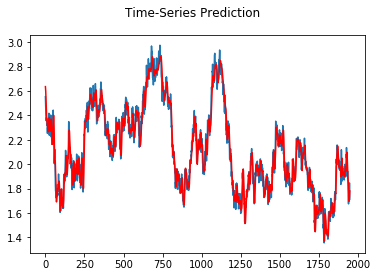

In [19]:
lstm.eval()

testX = testX.to(device)

error = 0
predictions = []
for batch_ind, (x_batch, y_batch) in enumerate(zip(test_dataloaderX, test_dataloaderY)):
    x_batch = x_batch.to(device)

    outputs = lstm(x_batch).cpu().detach().numpy()
    
    predictions.extend(outputs)
    error += mean_squared_error(y_batch, outputs)
    
print('Test MSE: %.6f' % error)


plt.plot(testY)
plt.plot(predictions, color='red')
plt.suptitle('Time-Series Prediction')
plt.show()